Loaded T2_2000-03.nc with Dask chunks
Loaded SNOWNC_2000-03.nc with Dask chunks
Loaded HAILNC_2000-03.nc with Dask chunks
Loaded GRAUPELNC_2000-03.nc with Dask chunks
Loaded I_RAINNC_2000-03.nc with Dask chunks
Loaded RAINNC_2000-03.nc with Dask chunks


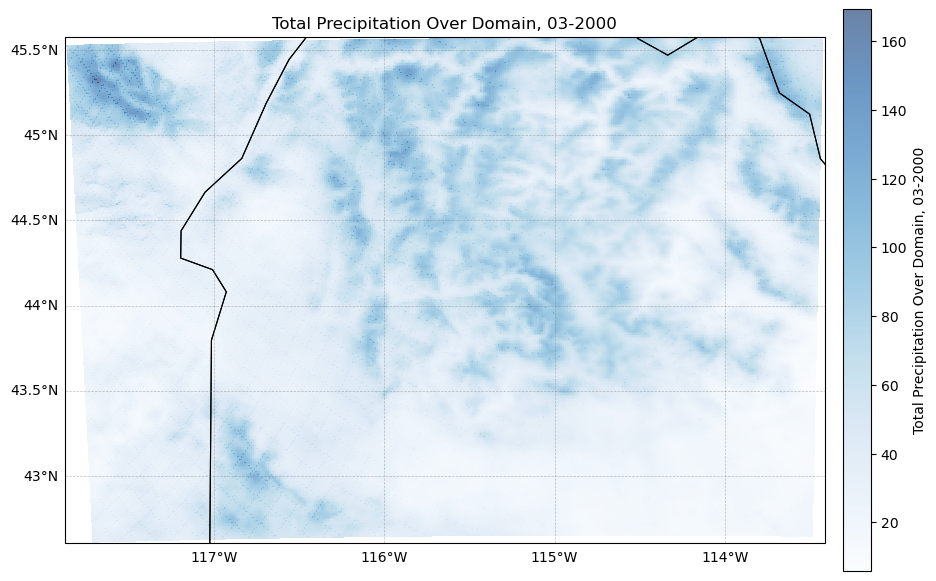

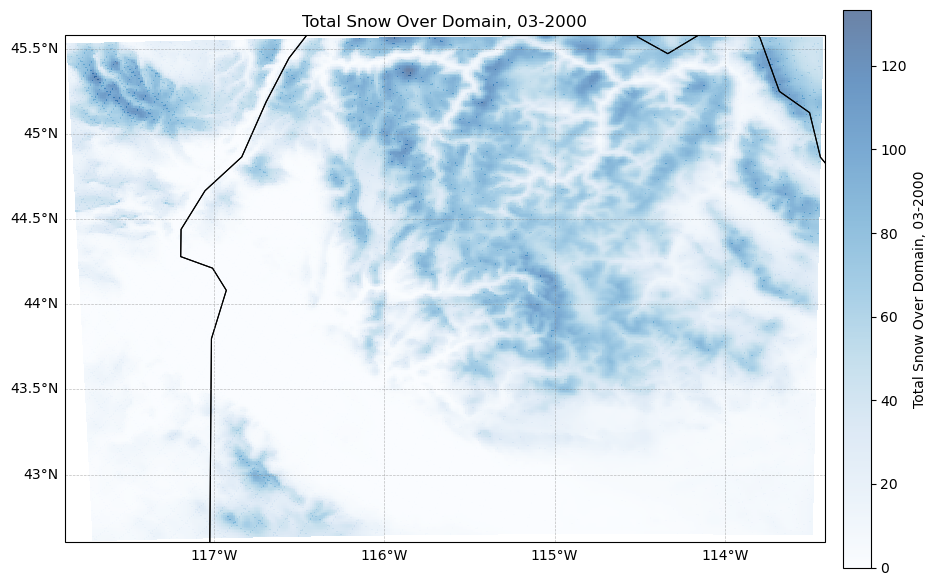

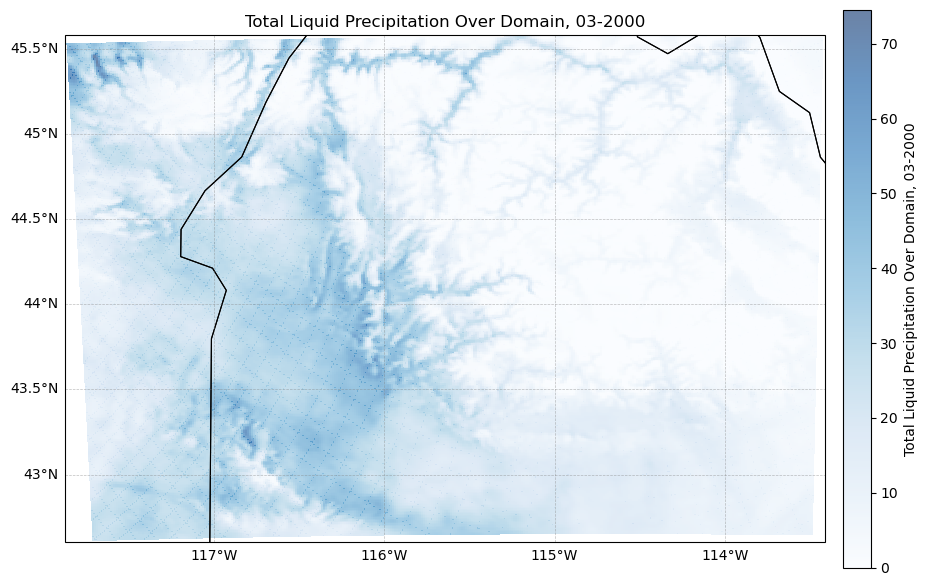

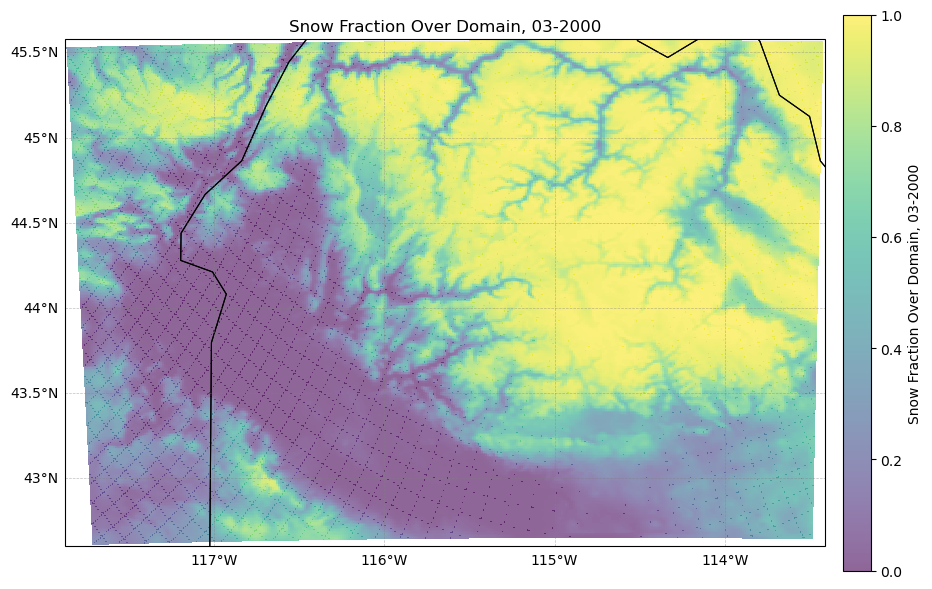

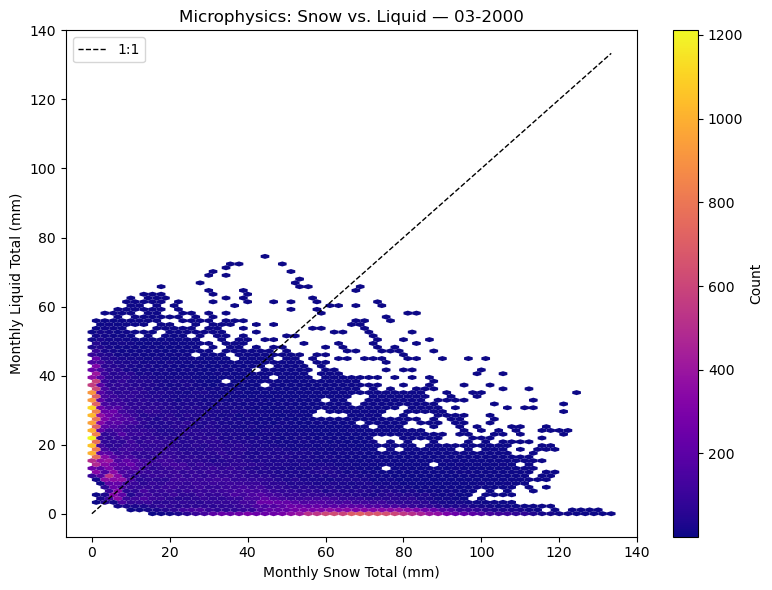

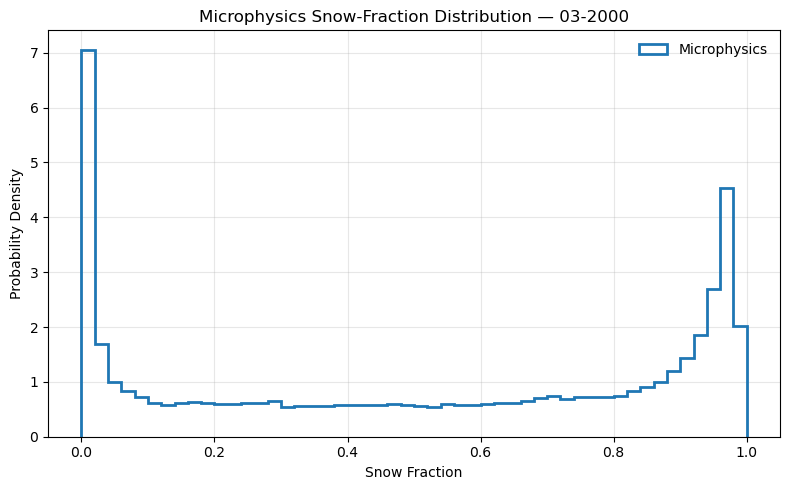

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import plot_utils
reload(plot_utils)
from plot_utils import plot_cartopy, load_wrf_var, plot_hexbin

# === DATA DIRECTORIES ===
d01_dir = "/bsushare/leaf-shared/subset-output-wrf/vol04/wrf_out/wy_2000/d01/"
d02_dir = "/bsushare/leaf-shared/subset-output-wrf/vol04/wrf_out/wy_2000/d02/"

# === CONFIGURATION ===
current_plot_file = d02_dir # update based on which dataset to plot
month = "03"
year = "2000"
target_location = "Domain"
epsilon = 1e-6 # avoid division by zero
min_precip = 1.0 # threshold for masking (mm)

# === LOAD DATA ===
t2 = load_wrf_var("T2", current_plot_file, year, month)
lats = t2['XLAT'][0].values
lons = t2['XLONG'][0].values
snownc = load_wrf_var("SNOWNC", current_plot_file, year, month)
hailnc = load_wrf_var("HAILNC", current_plot_file, year, month)
graup = load_wrf_var("GRAUPELNC", current_plot_file, year, month)
count  = load_wrf_var("I_RAINNC", current_plot_file, year, month)["I_RAINNC"]
rainnc = load_wrf_var("RAINNC",  current_plot_file, year, month)["RAINNC"]

# === CALCULATE TOTALS ===
rain2d = (count*100 + rainnc)
precip_total = rain2d.diff("Time", label="upper").fillna(0).sum("Time")
snow_total = snownc['SNOWNC'].diff(dim='Time').clip(min=0).sum(dim='Time')
hail_total = hailnc['HAILNC'].diff(dim='Time').clip(min=0).sum(dim='Time')
graup_total = graup['GRAUPELNC'].diff(dim='Time').clip(min=0).sum(dim='Time')
liquid_total = precip_total - snow_total - hail_total - graup_total
snow_frac_da = snow_total / (precip_total + epsilon)

# === MASKED ARRAYS ===
precip_ma = np.ma.masked_where(precip_total.values < min_precip, precip_total.values)
snow_ma = np.ma.masked_where(precip_total.values < min_precip, snow_total.values)
liquid_ma = np.ma.masked_where(precip_total.values < min_precip, liquid_total.values)
mask_frac = (precip_total.values < min_precip) | (~np.isfinite(snow_frac_da.values))
frac_ma = np.ma.masked_where(mask_frac, snow_frac_da.values)

# === PLOT ===
plot_cartopy(lons, lats, precip_ma,
 f"Total Precipitation Over {target_location}, {month}-{year}",
 cmap="Blues")

plot_cartopy(lons, lats, snow_ma,
 f"Total Snow Over {target_location}, {month}-{year}",
 cmap="Blues")

plot_cartopy(lons, lats, liquid_ma,
 f"Total Liquid Precipitation Over {target_location}, {month}-{year}",
 cmap="Blues")

plot_cartopy(lons, lats, frac_ma,
 f"Snow Fraction Over {target_location}, {month}-{year}",
 cmap="viridis", vmin=0, vmax=1)

# === COMPRESS & HEXBIN ===
snow_vals = snow_ma.compressed()
liq_vals  = liquid_ma.compressed()
plot_hexbin(
    snow_vals,
    liq_vals,
    gridsize=60,
    cmap="plasma",
    xlabel="Monthly Snow Total (mm)",
    ylabel="Monthly Liquid Total (mm)",
    title="Microphysics: Snow vs. Liquid — 03-2000",
    overlay_one_one=True
)

snow_frac_micro = frac_ma.compressed()
bins = np.linspace(0, 1, 51)
plt.figure(figsize=(8,5))
plt.hist(snow_frac_micro,
         bins=bins,
         density=True,
         histtype='step',
         linewidth=2,
         label='Microphysics')
plt.xlabel("Snow Fraction")
plt.ylabel("Probability Density")
plt.title(f"Microphysics Snow‐Fraction Distribution — {month}-{year}")
plt.legend(frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

